# Je teste des trucs ici

## V0 dégueulasse ne pas venir ici

In [1]:
from pymongo import MongoClient

# Replace the following with your MongoDB URI, username, and password


import os
from os.path import join, dirname
from dotenv import load_dotenv

dotenv_path = join(dirname("../"), '.env')
load_dotenv(dotenv_path)

uri = os.environ.get("uri")
username = os.environ.get("username")
password = os.environ.get("password")


# Create a MongoClient instance
client = MongoClient(uri, username=username, password=password)

# Access a specific database
db = client['github']

# Print the list of collections in the database
print(db.list_collection_names())

C:\Users\Camille\AppData\Local\Temp\ipykernel_5556\3547234744.py:19: UserWarning: You appear to be connected to a CosmosDB cluster. For more information regarding feature compatibility and support please visit https://www.mongodb.com/supportability/cosmosdb
  client = MongoClient(uri, username=username, password=password)


KeyboardInterrupt: 

In [ ]:
repos = list(db['repos_old'].find())
repos_refined = list(db['repos_refined'].find())


In [ ]:
def extract_info_by_key(repos, key):
    return [repo[key] for repo in repos]

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Champs utilisés par le modèle
columns = ['title', 'body', 'issues_url']

data = np.empty((len(repos), 3), dtype=object)

for ii, doc in enumerate(repos[:]):
        
    # print(doc.keys())

    data[ii] = [doc['name'], doc['description'], doc['issues_url']]
        
df_repos_filter = pd.DataFrame(columns=columns, data=data)
        
df_repos_filter
    

,title,body,issues_url
0,lila,"♞ lichess.org: the forever free, adless and op...",https://api.github.com/repos/lichess-org/lila/...
1,arangodb,🥑 ArangoDB is a native multi-model database wi...,https://api.github.com/repos/arangodb/arangodb...
2,misskey,🌎 A completely free and open interplanetary mi...,https://api.github.com/repos/misskey-dev/missk...
3,ComfyUI,The most powerful and modular diffusion model ...,https://api.github.com/repos/comfyanonymous/Co...
4,PipePipe,"A FLOSS Android app to let you browse YouTube,...",https://api.github.com/repos/InfinityLoop1308/...
...,...,...,...
2995,jsoup,"jsoup: the Java HTML parser, built for HTML ed...",https://api.github.com/repos/jhy/jsoup/issues{...
2996,VueTorrent,The sleekest looking WEBUI for qBittorrent mad...,https://api.github.com/repos/VueTorrent/VueTor...
2997,gitbutler,"The GitButler version control client, backed b...",https://api.github.com/repos/gitbutlerapp/gitb...
2998,self-operating-computer,A framework to enable multimodal models to ope...,https://api.github.com/repos/OthersideAI/self-...


### Méthodes du script

In [ ]:


import numpy as np
import requests
import os
import json


def extract_issues(url):
    """
    Extracts issues from a given GitHub repository URL and processes the data.
    This function sends a GET request to the provided URL to fetch issues data in JSON format.
    It then extracts specified fields ("title", "body", "labels") from each issue, processes the labels,
    and returns the data as a pandas DataFrame.
    Args:
        url (str): The URL of the GitHub repository issues API endpoint.
    Returns:
        pandas.DataFrame: A DataFrame containing the extracted issues data with columns for "title", "body",
                          and "issues_labels" (a list of label names for each issue).
                          Returns None if the request fails.
    Raises:
        requests.exceptions.RequestException: If there is an issue with the GET request.
    """

    fields = ("title", "body", "labels")


    # Send a GET request to the URL
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Convert the response to a dictionary
        issues_dict = response.json()
        
        # Save the dictionary to a JSON file
        with open('issues.json', 'w') as f:
            json.dump(issues_dict, f)
        
        # Load the dictionary from the JSON file
        with open('issues.json', 'r') as f:
            issues_dict = json.load(f)
        
        # Delete the JSON file
        os.remove('issues.json')
        
        # Extract the specified fields
        extracted_data = []
        for issue in issues_dict:
            extracted_issue = {field: issue.get(field, None) for field in fields}
            extracted_data.append(extracted_issue)
        
        
        # Convert the extracted issues to a numpy array where each key is a column and each value is a value in the array
        if extracted_data:
            keys = extracted_data[0].keys()
            
            extracted_data_array = np.array([[issue[key] for key in keys] for issue in extracted_data], dtype=object)
            extracted_data_df = pd.DataFrame(extracted_data_array, columns=keys)
            
        
        else:
            print("No issues extracted.")


        # Nouvelle colonne de type object, va recevoir des listes de noms de labels d'issues
        extracted_data_df['issues_labels'] = pd.Series(dtype=object)

        # Replace the content of the "labels" field with only the names of each dict
        if extracted_data:
            for ii, issue in enumerate(extracted_data):
                
                # print(issue.keys())
                if 'labels' in issue and isinstance(issue['labels'], list):
                    
                    extracted_data_df.at[ii, "issues_labels"] = [label['name'] for label in issue['labels'] if 'name' in label]
                    # print(tmp)
                    

        extracted_data_df.drop("labels", axis=1, inplace=True)
        
        
        
        
        return extracted_data_df
    else:
        print(f"Failed to download the JSON file. Status code: {response.status_code}")
        return None




In [ ]:

from tqdm import tqdm

df_total = pd.DataFrame(columns=('title', 'body', 'issues_labels'))

import time

for url in tqdm(df_repos_filter['issues_url'][:100]):
    
    # Je coupe la fin de l'url :
    # https://api.github.com/repos/lichess-org/lila/issues
    # à la place de
    # https://api.github.com/repos/lichess-org/lila/issues{/number}
    url = url[:-9]

    extracted_data_df = extract_issues(url)
    
    df_total = pd.concat((df_total, extracted_data_df))
    time.sleep(5)

    # print(repo['issues_url'])

  0%|          | 0/100 [00:00<?, ?it/s]

Failed to download the JSON file. Status code: 403


  1%|          | 1/100 [00:05<08:30,  5.15s/it]

Failed to download the JSON file. Status code: 403


  1%|          | 1/100 [00:10<17:02, 10.33s/it]


KeyboardInterrupt: 

In [ ]:
# Example usage
url = "https://api.github.com/repos/Tom94/tev/issues"
extracted_data_df = extract_issues(url)




extracted_data_df

,title,body,issues_labels
0,Reads attributes from exr header and display t...,"Hello,\r\nI have added a way to retrieve the E...",[]
1,[Featrure Request] Add support for JPEG XL,JPEG XL is a new format that offers HDR suppor...,[]
2,Feature request: square style macOS icon,Thanks for the great app!\r\nCould you please ...,[]
3,vulnerability in tev,"hello,\r\ni found vulnerability in tev, where ...",[]
4,Add tonemapper that hashes to a random color,"Hi Thomas,\r\n\r\nThanks for this fantastic im...",[]
5,Feature request: report bit depth,It would be nice to be able to know the bit de...,[]
6,Feature Request: Allow changing of the viewer ...,When I'm opening images/HDRs/EXRs/Etc. I want ...,[]
7,Histogram could show statistics for RGB(A) cha...,"Hi there, especially now that we are [able to ...",[]
8,Ultra HDR (JPEG with gainmap) not supported,I've got a couple of HDR images generated by [...,[]
9,Compose two (or more) images together,Hi!\r\n\r\nWould it be possible to add a featu...,[]


In [ ]:
# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Convert the response to a dictionary
    issues_dict = response.json()
    
    # Print the keys of the first issue
    if issues_dict:
        print(issues_dict[0].keys())
    else:
        print("No issues found.")
else:
    print(f"Failed to download the JSON file. Status code: {response.status_code}")

dict_keys(['url', 'repository_url', 'labels_url', 'comments_url', 'events_url', 'html_url', 'id', 'node_id', 'number', 'title', 'user', 'labels', 'state', 'locked', 'assignee', 'assignees', 'milestone', 'comments', 'created_at', 'updated_at', 'closed_at', 'author_association', 'sub_issues_summary', 'active_lock_reason', 'draft', 'pull_request', 'body', 'closed_by', 'reactions', 'timeline_url', 'performed_via_github_app', 'state_reason'])


## V1 magnifique qui marche

In [ ]:
from pymongo import MongoClient

# Replace the following with your MongoDB URI, username, and password


import os
from os.path import join, dirname
from dotenv import load_dotenv

dotenv_path = join(dirname("../"), '.env')
load_dotenv(dotenv_path)

uri = os.environ.get("uri")
username = os.environ.get("username")
password = os.environ.get("password")


# Create a MongoClient instance
client = MongoClient(uri, username=username, password=password)

# Access a specific database
db = client['github']

# Print the list of collections in the database
print(db.list_collection_names())

C:\Users\Camille\AppData\Local\Temp\ipykernel_20928\3547234744.py:19: UserWarning: You appear to be connected to a CosmosDB cluster. For more information regarding feature compatibility and support please visit https://www.mongodb.com/supportability/cosmosdb
  client = MongoClient(uri, username=username, password=password)


['repos_refined', 'repos_old', 'repos', 'issues', 'issues_refined']


In [ ]:
# limite de résultats pour la query (0 pour infini)
limit_query = 0



issues = list(db['issues'].find({'labels': {'$ne': []}}, {'title': 1, 'body': 1, 'labels': 1, '_id': 0}).limit(limit_query))

for issue in issues:
    if 'labels' in issue and isinstance(issue['labels'], list):
        issue['labels'] = [label['name'] for label in issue['labels'] if 'name' in label]
        
        

# Create or replace the 'issues_refined' collection with the new data
db['issues_refined'].drop()
db['issues_refined'].insert_many(issues)

print("Traitement terminé")

KeyboardInterrupt: 

# Dataset pytorch, prétraitements


In [1]:
from pymongo import MongoClient

# Replace the following with your MongoDB URI, username, and password


import os
from os.path import join, dirname
from dotenv import load_dotenv

dotenv_path = join(dirname("../"), '.env')
load_dotenv(dotenv_path)

uri = os.environ.get("uri")
username = os.environ.get("username")
password = os.environ.get("password")


# Create a MongoClient instance
client = MongoClient(uri, username=username, password=password)

# Access a specific database
db = client['github']

# Print the list of collections in the database
print(db.list_collection_names())

C:\Users\Camille\AppData\Local\Temp\ipykernel_13836\3547234744.py:19: UserWarning: You appear to be connected to a CosmosDB cluster. For more information regarding feature compatibility and support please visit https://www.mongodb.com/supportability/cosmosdb
  client = MongoClient(uri, username=username, password=password)


['repos_refined', 'repos_old', 'repos', 'issues', 'issues_refined']


In [3]:
# Nombre d'éléments à extraire
import numpy as np
db_issues = db['issues_refined']

# Define the start and end bounds
ech_start = 0
ech_end = 50000

# Fetch the documents from the 'issues_refined' collection within the specified bounds, only the 'labels' field
random_issues = list(db_issues.find({}, {'labels': 1, '_id': 0}).skip(ech_start).limit(ech_end - ech_start))

# Flatten the 'labels' field into a single list
each_label = np.array([label for issue in random_issues for label in issue['labels']])

print(f"Nombre d'issues : {len(random_issues)}")
print(f"Nombre de labels : {len(each_label)}")


Nombre d'issues : 50000
Nombre de labels : 70766


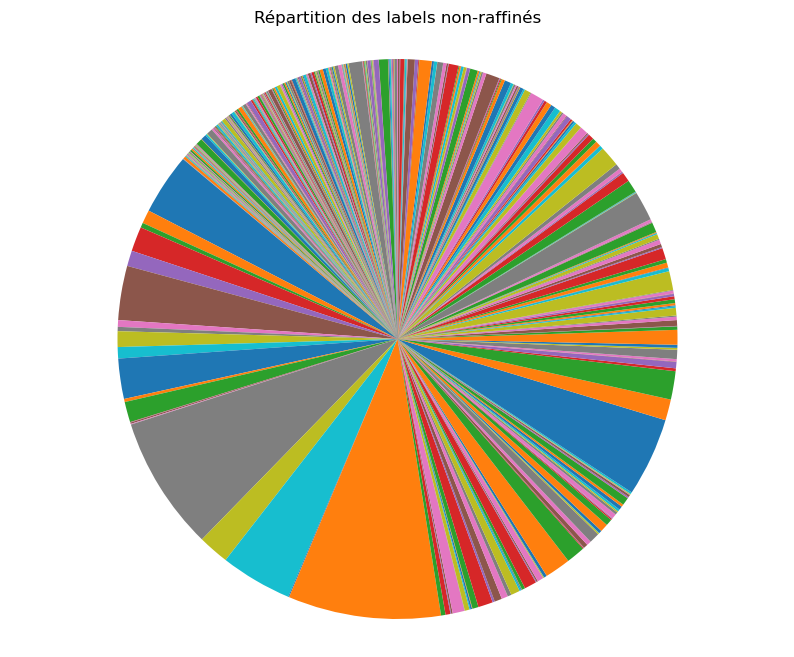

In [8]:
from collections import Counter
import matplotlib.pyplot as plt

# Compter la fréquence de chaque label
label_counts = Counter(each_label)

# Extraire les labels et leurs fréquences
labels, counts = zip(*label_counts.items())

# Créer le graphique camembert sans les labels
plt.figure(figsize=(10, 8))
plt.pie(counts, startangle=140)
plt.axis('equal')  # Assure que le graphique est un cercle
plt.title('Répartition des labels non-raffinés')
plt.show()


In [41]:
vector_size = 300

# Doc2Vec
from gensim.models import Doc2Vec

# K-means
num_clusters = 10


from gensim.models.doc2vec import TaggedDocument
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


import string
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt


# labels proposés par github
github_labels = {"bug", "documentation", "duplicate", "good first issue", "help wanted", "invalid", "question", "refactoring", "wontfix"}


####
# PREPARATION POUR LE D2V
####

words_to_tej = ["type"]
# Process labels by removing unwanted words and splitting by punctuation
processed_labels = []
dict_processed_labels = dict()

for label in each_label:
    # Split by punctuation and spaces
    
    if label not in dict_processed_labels:
        words = [word for part in label.split() for word in part.split(':')]
        filtered_words = [word.lower() for word in words if word.lower() not in words_to_tej]
        dict_processed_labels[label] = filtered_words
        processed_labels.append(filtered_words)
    
    else:
        processed_labels.append(dict_processed_labels[label])



####
# DOC2VEC
####

# Convert labels to TaggedDocument format for Doc2Vec
tagged_data = [TaggedDocument(words=label, tags=[str(i)]) for i, label in enumerate(processed_labels)]

# Train Doc2Vec model
model = Doc2Vec(vector_size=vector_size, window=5, min_count=1, workers=4, epochs=100)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# Get embeddings for each label
embeddings_labels = np.array([model.dv[str(i)] for i in range(len(processed_labels))])

# Embeddings des labels "officiels" de github
embeddings_github_labels = np.array([model.infer_vector(label.split()) for label in github_labels])



# Set similarity threshold
similarity_threshold = 0.5

# Calculate cosine similarity between each embedding in embeddings_labels and embeddings_github_labels
similarities = cosine_similarity(embeddings_labels, embeddings_github_labels)

# Find the most similar GitHub label for each embedding
assigned_labels = []
for similarity in similarities:
    max_similarity = np.max(similarity)
    if max_similarity >= similarity_threshold:
        most_similar_index = np.argmax(similarity)
        assigned_labels.append(list(github_labels)[most_similar_index])
    else:
        assigned_labels.append("garbage")


In [42]:
list(zip(processed_labels, assigned_labels))

[(['question'], 'question'),
 (['bug'], 'bug'),
 (['question'], 'question'),
 (['question'], 'question'),
 (['suggestion'], 'invalid'),
 (['bug'], 'bug'),
 (['question'], 'question'),
 (['bug'], 'bug'),
 (['suggestion'], 'garbage'),
 (['question-其他疑问'], 'help wanted'),
 (['question'], 'question'),
 (['bug'], 'bug'),
 (['question'], 'question'),
 (['bug'], 'bug'),
 (['bug'], 'bug'),
 (['bug'], 'bug'),
 (['suggestion'], 'garbage'),
 (['bug'], 'bug'),
 (['question'], 'question'),
 (['question'], 'question'),
 (['bug'], 'bug'),
 (['question'], 'question'),
 (['question'], 'question'),
 (['bug'], 'bug'),
 (['need', 'more', 'info(demo?)'], 'garbage'),
 (['need', 'more', 'info(demo?)'], 'garbage'),
 (['bug'], 'bug'),
 (['bug'], 'bug'),
 (['question'], 'question'),
 (['question'], 'question'),
 (['bug'], 'bug'),
 (['question'], 'question'),
 (['bug'], 'bug'),
 (['question'], 'question'),
 (['bug'], 'bug'),
 (['question'], 'question'),
 (['question'], 'question'),
 (['question'], 'question'),
 

In [43]:
len(assigned_labels)

69875

In [44]:
len(random_issues)

50000

In [ ]:
# # Copier la colonne "labels" dans une nouvelle colonne "assigned_issues"
# db_issues.update_many({}, [{'$addFields': {'assigned_issues': '$labels'}}])

# print("Colonne 'assigned_issues' ajoutée avec succès.")

Colonne 'assigned_issues' ajoutée avec succès.


In [49]:
# Créer une liste locale des nouveaux labels à associer à chaque label existant
new_assigned_labels = []

# Créer un dictionnaire qui associe chaque processed_label à un assigned_label
label_mapping = {tuple(label): assigned_label for label, assigned_label in zip(processed_labels, assigned_labels)}

for issue in db_issues.find():
    updated_labels = []
    for label in issue.get('labels', []):
        label_tuple = tuple(dict_processed_labels.get(label, [label]))
        if label_tuple in label_mapping:
            updated_labels.append(label_mapping[label_tuple])
        else:
            updated_labels.append(label)
    new_assigned_labels.append(updated_labels)

# Ajouter la nouvelle colonne "assigned_issues" dans la base de données
for issue, new_labels in zip(db_issues.find(), new_assigned_labels):
    db_issues.update_one({'_id': issue['_id']}, {'$set': {'assigned_issues': new_labels}})

print("Mise à jour des assigned_issues terminée.")


CursorNotFound: Cursor 4140316821300535 not found, full error: {'ok': 0.0, 'errmsg': 'Cursor 4140316821300535 not found', 'code': 43, 'codeName': 'CursorNotFound'}

## Vieux Kmeans que je n'utilise plus

In [ ]:

# ####
# # K-MEANS
# ####


# # Perform K-means clustering
# kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(embeddings)
# labels = kmeans.labels_

# # Rename each cluster label with the most frequent string in the cluster
# cluster_names = []
# for i in range(num_clusters):
#     cluster_labels = np.array([' '.join(label) for label in processed_labels])[labels == i]
#     most_frequent_label = max(set(cluster_labels), key=list(cluster_labels).count)
#     cluster_names.append(most_frequent_label)

# # Reduce the dimensionality of the embeddings for visualization
# pca = PCA(n_components=2)
# reduced_embeddings = pca.fit_transform(embeddings)

# # Plot the reduced embeddings with cluster labels
# plt.figure(figsize=(10, 7))

# # Print the cluster names
# for i, name in enumerate(cluster_names):
#     print(f'Cluster {i}: {name}')
#     cluster_points = reduced_embeddings[labels == i]
#     plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i} : {name}')
    
# plt.title('K-means Clustering of Labels')
# plt.xlabel('PCA Component 1')
# plt.ylabel('PCA Component 2')
# plt.legend()
# plt.show()